# Text Classification for Topic Modelling

## Notebook Imports

In [1]:
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
from nltk.corpus import wordnet
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Hyperparameters

In [4]:
DATASET_ROOT = '/kaggle/input/topic-modeling-for-research-articles/Train.csv'

# Data Loading

In [5]:
train_df = pd.read_csv(DATASET_ROOT)
train_df.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing

In [6]:
# Dropping ID
train_df.drop('id', axis=1, inplace=True)

# Resetting ID 
train_df.reset_index()

topics = train_df.columns[1:]
train_df['Target'] = train_df[topics].idxmax(axis=1)
train_df.drop(topics, axis=1, inplace=True)
train_df.head()

,ABSTRACT,Target
0,a ever-growing datasets inside observational a...,Physics
1,we propose the framework considering optimal $...,Computer Science
2,nanostructures with open shell transition meta...,Physics
3,stars are self-gravitating fluids inside which...,Physics
4,deep neural perception and control networks ar...,Computer Science


In [7]:
encoder = LabelEncoder()
train_df['Target_Label'] = encoder.fit_transform(train_df['Target'])

In [8]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer()) -> list:
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    return preprocessed_text

In [9]:
nested_list = train_df.ABSTRACT.apply(preprocess_text)
nested_list.head()

0    [datasets, inside, observational, astronomy, c...
1    [propose, framework, considering, optimal, exc...
2    [nanostructures, open, shell, transition, meta...
3    [star, fluid, inside, pressure, buoyancy, rota...
4    [deep, neural, perception, control, network, l...
Name: ABSTRACT, dtype: object

In [10]:
train_df['ABSTRACT'] = nested_list
train_df.head()

,ABSTRACT,Target,Target_Label
0,"[datasets, inside, observational, astronomy, c...",Physics,2
1,"[propose, framework, considering, optimal, exc...",Computer Science,0
2,"[nanostructures, open, shell, transition, meta...",Physics,2
3,"[star, fluid, inside, pressure, buoyancy, rota...",Physics,2
4,"[deep, neural, perception, control, network, l...",Computer Science,0


In [11]:
def word_count(topic_name=str):
    words = train_df[train_df['Target'] == topic_name]['ABSTRACT']
    all_topic_words = [item for sublist in list(words) for item in sublist]
    words_series = pd.Series(all_topic_words).value_counts()
    return all_topic_words, words_series

In [12]:
cs_list_words, cs_series = word_count(topic_name='Computer Science')
ph_list_words, ph_series = word_count(topic_name='Physics')
math_list_words, math_series = word_count(topic_name='Mathematics')
stats_list_words, stats_series = word_count(topic_name='Statistics')

### Building Vocabulary and Encoding Text

In [13]:
# Build vocabulary
vocab = build_vocab_from_iterator(nested_list, specials=["<pad>", "<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

# Convert tokens to indices
def encode(text):
    return [vocab[token] for token in text]

encoded_data = [encode(text) for text in nested_list]

In [14]:
padded_data = pad_sequence([torch.tensor(seq) for seq in encoded_data], batch_first=True, padding_value=vocab['<pad>'])

In [15]:
train_df['Encoded & Padded Text'] = padded_data.tolist()
train_df.head()

,ABSTRACT,Target,Target_Label,Encoded & Padded Text
0,"[datasets, inside, observational, astronomy, c...",Physics,2,"[140, 2, 1087, 2624, 7251, 3218, 2, 91, 725, 1..."
1,"[propose, framework, considering, optimal, exc...",Computer Science,0,"[33, 57, 3, 112, 6777, 2771, 2, 2581, 68, 22, ..."
2,"[nanostructures, open, shell, transition, meta...",Physics,2,"[6594, 474, 2427, 144, 917, 769, 3430, 765, 23..."
3,"[star, fluid, inside, pressure, buoyancy, rota...",Physics,2,"[126, 712, 2, 577, 6052, 899, 85, 39, 69, 7144..."
4,"[deep, neural, perception, control, network, l...",Computer Science,0,"[54, 49, 1674, 77, 7, 891, 295, 172, 503, 4, 3..."


In [16]:
df = train_df[['Encoded & Padded Text', 'Target_Label']]
df.head()

,Encoded & Padded Text,Target_Label
0,"[140, 2, 1087, 2624, 7251, 3218, 2, 91, 725, 1...",2
1,"[33, 57, 3, 112, 6777, 2771, 2, 2581, 68, 22, ...",0
2,"[6594, 474, 2427, 144, 917, 769, 3430, 765, 23...",2
3,"[126, 712, 2, 577, 6052, 899, 85, 39, 69, 7144...",2
4,"[54, 49, 1674, 77, 7, 891, 295, 172, 503, 4, 3...",0


## Data Visualization

<Axes: xlabel='Target', ylabel='count'>

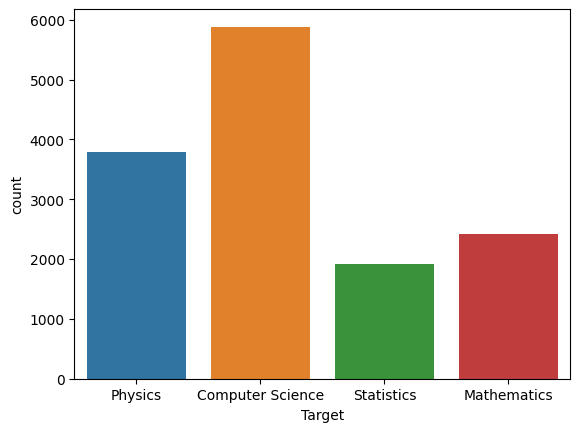

In [17]:
sns.countplot(data=train_df, x='Target')

In [18]:
def plot_word_cloud(list_words: list, ax, title: str):
    cs_str = " ".join(list_words)
    
    word_cloud = WordCloud(max_font_size=50, max_words=1000, 
                           background_color="white", colormap = 'Paired')
    word_cloud.generate(cs_str.upper())
    
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=30)

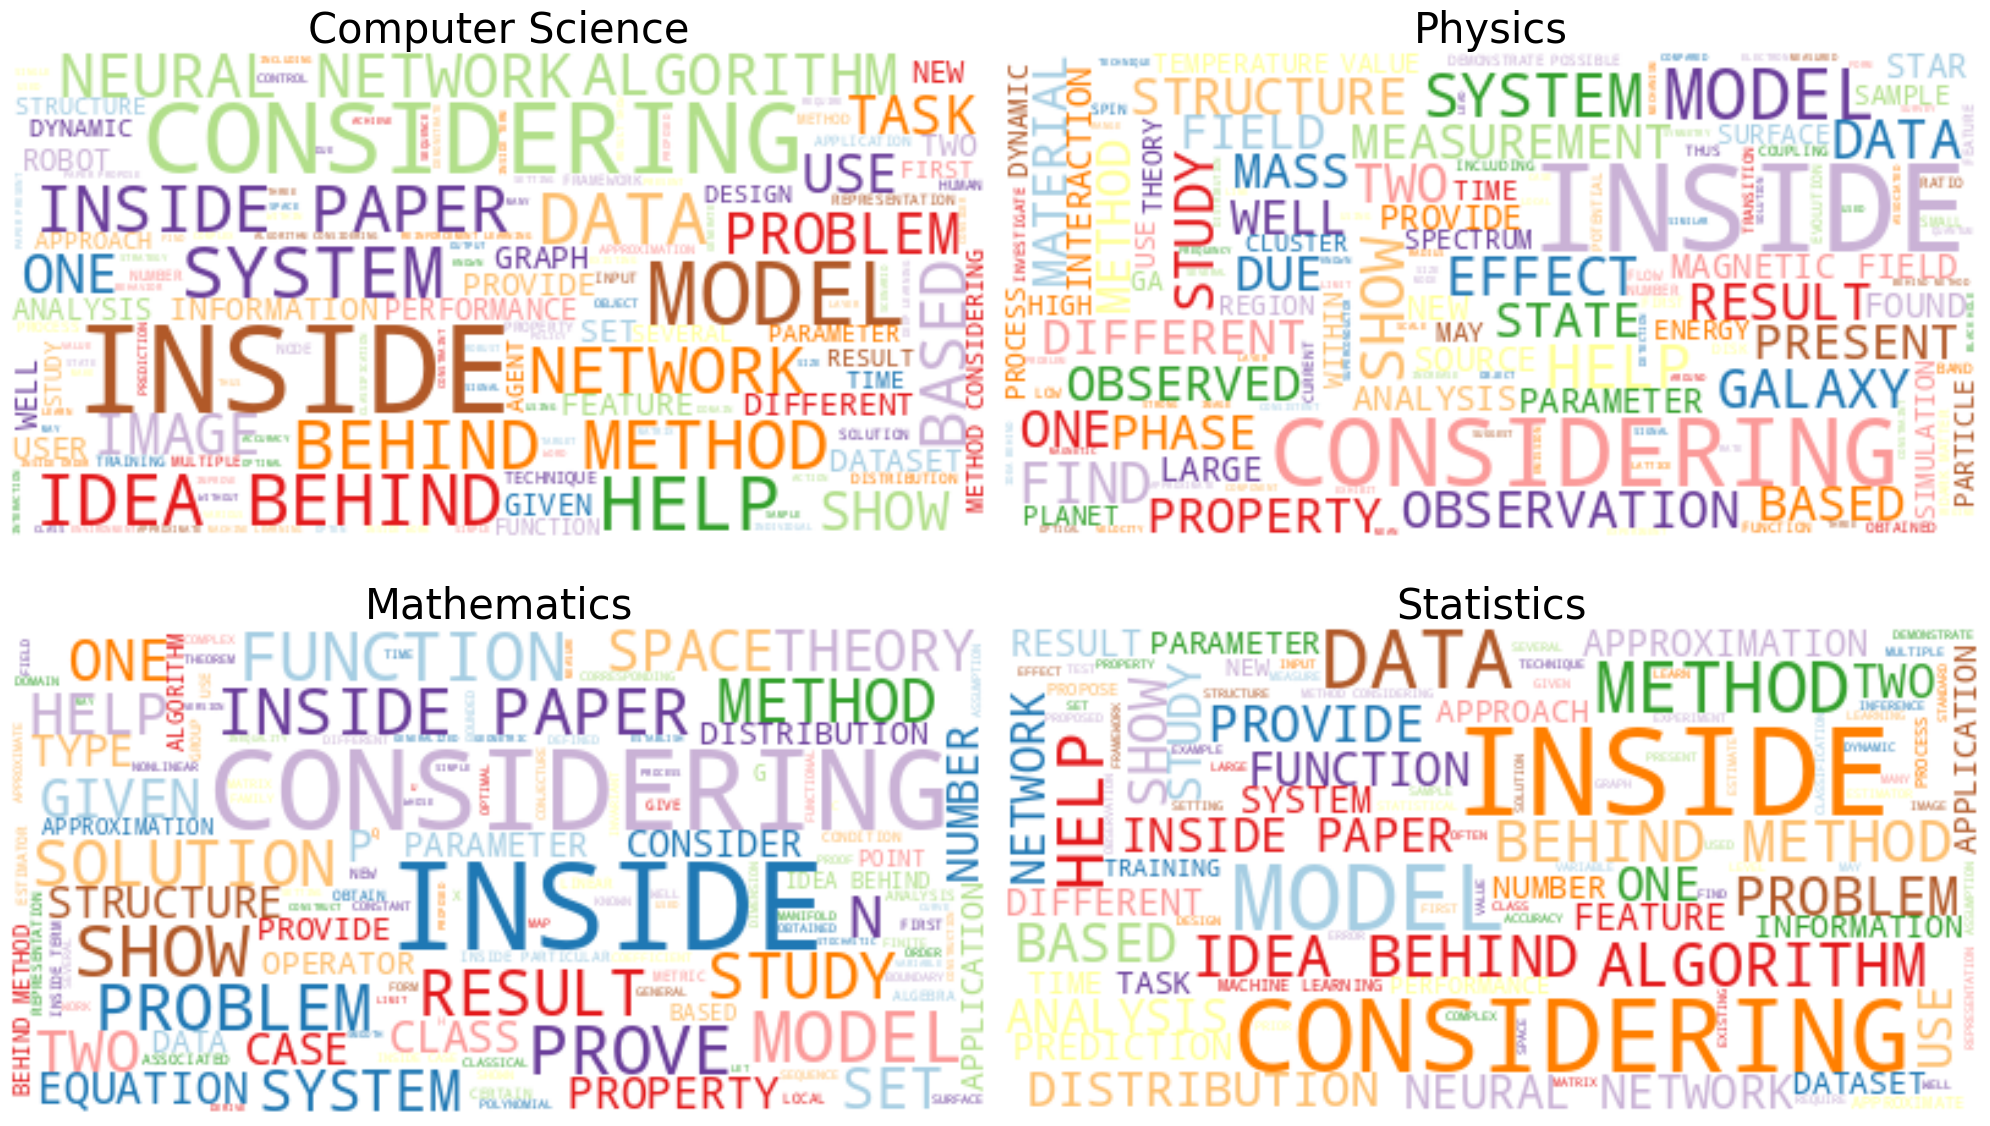

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plot_word_cloud(cs_list_words, axs[0, 0], 'Computer Science')
plot_word_cloud(ph_list_words, axs[0, 1], 'Physics')
plot_word_cloud(math_list_words, axs[1, 0], 'Mathematics')
plot_word_cloud(stats_list_words, axs[1, 1], 'Statistics')
plt.tight_layout()
plt.show()

## Model Building

In [20]:
class LSTM(nn.Module): 
    def __init__(self, vocab_size, num_labels, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, droupout=0.2)
        
        self.output_layer = nn.Linear(hidden_size, num_labels)
        
    def forward(self, input_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_seq)
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        return self.output_layer(output), hidden_out, mem_out

In [21]:
X, y = df['Encoded & Padded Text'], df['Target_Label']
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)